In [ ]:
import torch
cuda_enable = True
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


In [ ]:
import os
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn
from pycocotools.coco import COCO
from torchvision import datasets, transforms, models

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, root, annotation, transforms=None):
    self.root = root
    self.transforms = transforms
    self.coco = COCO(annotation)
    self.ids = list(sorted(self.coco.imgs.keys()))

  def __getitem__(self, idx):
    # image ID
    img_id = self.ids[idx]
    # image file_name
    img_file = self.coco.loadImgs(img_id)[0]["file_name"]
    # read_imgae
    img = Image.open(os.path.join(self.root, img_file))
    # get annotation ID
    ann_ids = self.coco.getAnnIds(imgIds = img_id)
    # read annotation
    anns = self.coco.loadAnns(ann_ids)
    # num of people in the picture
    num_objs = len(anns)
    # build information about bounding box & area
    boxes = []
    areas = []
    for i in range(num_objs):
      x_min = anns[i]['bbox'][0]
      y_min = anns[i]['bbox'][1]
      x_max = x_min + anns[i]['bbox'][2]
      y_max = y_min + anns[i]['bbox'][3]
      boxes.append([x_min, y_min, x_max, y_max])
      areas.append(anns[i]['area'])

    # transfer information to Tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.ones((num_objs,), dtype = torch.int64)
    img_id = torch.tensor([img_id])
    areas = torch.as_tensor(areas, dtype=torch.float32)
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    # Annotation in dict form
    Annotations = {
        "boxes" : boxes,
        "labels" : labels,
        "image_id" : img_id,
        "area" : areas,
        "iscrowd" : iscrowd
    }

    # transforms
    if self.transforms is not None:
      img = self.transforms(img)

    return img, Annotations

  def __len__(self):
    return len(self.ids)

In [ ]:
def get_transforms(train):
  trans = []
  if train:
    trans.append(transforms.RandomHorizontalFlip(0.5))
    # trans.append(transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)))
    # trans.append(transforms.ColorJitter(brightness=1, contrast=1, saturation=1))
  trans.append(transforms.ToTensor())
  return transforms.Compose(trans)

train_data_path = '/content/Pedestrian/PNGImages'
coco_path = '/content/Pedestrian/Json/train.json'
train_dataset = ImageDataset(root=train_data_path, annotation=coco_path, transforms=get_transforms(train=True))

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(train_dataset, 2, shuffle=True, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [ ]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 244MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# change question to binary classification (human, not human)
num_classes = 2

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
for x,y in train_loader:
  print(y)
  break

({'boxes': tensor([[ 32., 102.,  64., 183.],
        [ 55., 107.,  89., 191.],
        [ 79., 106., 120., 206.],
        [114., 102., 144., 177.],
        [146., 106., 179., 186.],
        [190., 115., 224., 198.],
        [219., 109., 249., 182.],
        [242., 107., 253., 135.],
        [252., 108., 264., 139.],
        [254., 109., 279., 173.],
        [249., 105., 293., 216.],
        [295., 114., 323., 183.],
        [345., 112., 375., 188.],
        [336., 107., 354., 151.],
        [332., 112., 344., 145.]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'image_id': tensor([52]), 'area': tensor([2592., 2856., 4100., 2250., 2640., 2822., 2190.,  308.,  372., 1600.,
        4884., 1932., 2280.,  792.,  396.]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}, {'boxes': tensor([[207., 100., 272., 262.],
        [175., 103., 211., 190.],
        [249., 104., 280., 180.],
        [285., 104., 307., 160.],
        [274., 105., 295., 158.],
        

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

epochs = 12
model = model.to(device)

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/rcnn_model/model_1"))

<All keys matched successfully>

In [ ]:


for _ in range(epochs):
  model.train()
  i = 0
  for imgs, annotations in train_loader:
    i += 1
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k:v.to(device) for k, v in t.items()} for t in annotations]
    loss_dict = model(imgs, annotations)
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    print("Iteration: {}; Loss: {}".format(i, losses))
  lr_scheduler.step()

Iteration: 1; Loss: 0.7126653790473938
Iteration: 2; Loss: 0.8150871396064758
Iteration: 3; Loss: 0.1148892194032669
Iteration: 4; Loss: 0.1966404765844345
Iteration: 5; Loss: 0.9920255541801453
Iteration: 6; Loss: 0.5026324391365051
Iteration: 7; Loss: 0.13357441127300262
Iteration: 8; Loss: 0.9977993965148926
Iteration: 9; Loss: 0.34370025992393494
Iteration: 10; Loss: 0.18715079128742218
Iteration: 11; Loss: 0.46213847398757935
Iteration: 12; Loss: 0.386522501707077
Iteration: 13; Loss: 0.07426131516695023
Iteration: 14; Loss: 0.6894117593765259
Iteration: 15; Loss: 0.7823070883750916
Iteration: 16; Loss: 0.18584968149662018
Iteration: 17; Loss: 0.982885479927063
Iteration: 18; Loss: 0.9923375248908997
Iteration: 19; Loss: 1.132037878036499
Iteration: 20; Loss: 0.3720507025718689
Iteration: 21; Loss: 0.5541871190071106
Iteration: 22; Loss: 0.43105632066726685
Iteration: 23; Loss: 0.5902782678604126
Iteration: 24; Loss: 0.7814216613769531
Iteration: 25; Loss: 0.3471923768520355
Itera

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/rcnn_model/model_1")

In [ ]:
def im_convert(tensor):
    image = tensor.clone().detach().cpu().numpy()

    # [C, W, H] --> [W, H, C]
    image = image.transpose(1, 2, 0)

    # denormalize
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))


    image = image.clip(0, 1)

    return image

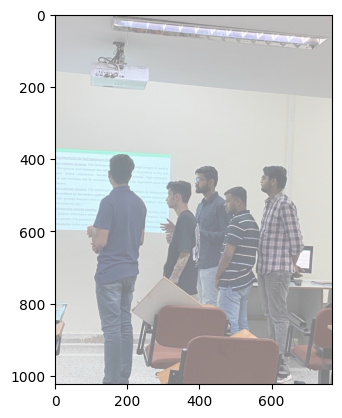

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# use 10.pic to illustrate performance for a single picture.
img = cv2.imread("test3.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# transfer array to pillow format
val_tran = get_transforms(train=False)
im_pil = Image.fromarray(img)
im_pil = val_tran(im_pil)
plt.imshow(im_convert(im_pil))

image = im_pil.to(device)
model_val = model.eval()
output = model([image])
# print(output)

5


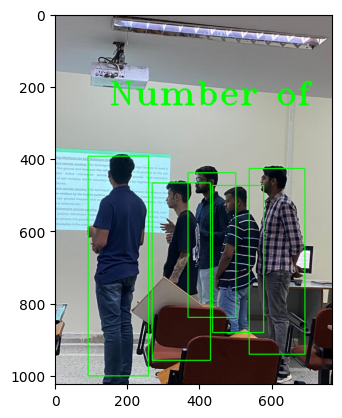

True

In [ ]:
scores = output[0]['scores'].detach().cpu().numpy()
num_people = len(scores[scores > 0.7])
print(num_people)
boxes = output[0]['boxes'].detach().cpu().numpy()
boxes = boxes[:num_people]


for i in range(num_people):
  pt1 = (int(boxes[i][0]), int(boxes[i][1]))
  pt2 = (int(boxes[i][2]), int(boxes[i][3]))
  img = cv2.rectangle(img, pt1, pt2, (0, 255, 0), 2)
text=f"Number of people = {num_people}"
cv2.putText(img=img, text=text, org=(150, 250), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=3, color=(0, 255, 0),thickness=3)
plt.imshow(img)
plt.show()
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output.jpeg', img)

In [ ]:
def get_num_person(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # transfer array to pillow format
  val_tran = get_transforms(train=False)
  im_pil = Image.fromarray(img)
  im_pil = val_tran(im_pil)

  image = im_pil.to(device)
  model_val = model.eval()
  output = model([image])
  scores = output[0]['scores'].detach().cpu().numpy()
  num_people = len(scores[scores > 0.7])
  return num_people

In [ ]:
preds = []

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/dataset/"

In [ ]:
"15".rjust(3,"0")

'015'

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
for i in tqdm(range(1,118)):
  file_path = f"{path}{str(i).rjust(3,'0')}.png"
  preds.append(get_num_person(file_path))

  0%|          | 0/117 [00:00<?, ?it/s]

In [ ]:
len(preds)

117

In [ ]:
import pandas as pd
df = pd.read_csv("/content/human_count - Sheet1 (1).csv")

In [ ]:
df.head()

,Actual
0,2
1,2
2,4
3,5
4,3


In [ ]:
df['pred'] = preds

In [ ]:
(df['Actual']==df['pred']).sum()*100/df.shape[0]

76.92307692307692

In [ ]:
df.to_csv("predictions.csv",index=False)